## Imports

In [24]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from src.helpers import *

## Getting data

In [25]:
np.random.seed(42)
torch.manual_seed(42)
tf.random.set_seed(42)
keras.utils.set_random_seed(42)

X, y = load_california()
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y.reshape(-1, 1)).ravel()

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

Xtr_t, Xte_t = map(torch.FloatTensor, (X_tr, X_te))
ytr_t, yte_t = map(lambda v: torch.FloatTensor(v.reshape(-1, 1)), (y_tr, y_te))

Xtr_tf, Xte_tf = map(lambda a: tf.convert_to_tensor(a, tf.float32), (X_tr, X_te))
ytr_tf, yte_tf = map(lambda v: tf.convert_to_tensor(v.reshape(-1, 1), tf.float32), (y_tr, y_te))

## Defining hyperparameters

In [26]:
EPOCHS, BATCH = 50, 32
LR = {
    "SGD":          1e-3,
    "SGD+Momentum": 1e-4,
    "SGD+Nesterov": 1e-4,
    "Adagrad":      1e-2,
    "RMSprop":      1e-2,
    "Adam":         1e-2,
}

## Training models and plotting results

/Users/aleksandr/Desktop/itmo/s4/optimisation-methods/Stochastic-Gradient-Descent/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Opt            Framework   MSE           Time(s)  Mem(MB) 
-----------------------------------------------------------
SGD            PyTorch     4.1912e-01    3.17     19.62   
SGD+Momentum   PyTorch     4.1662e-01    4.48     0.30    
SGD+Nesterov   PyTorch     4.0902e-01    3.05     0.73    
Adagrad        PyTorch     4.3026e-01    3.07     3.03    
RMSprop        PyTorch     4.6188e-01    3.08     0.48    
Adam           PyTorch     4.2270e-01    3.48     -0.17   
SGD            TensorFlow  4.1000e-01    32.64    47.64   
SGD+Momentum   TensorFlow  4.0989e-01    38.07    26.62   
SGD+Nesterov   TensorFlow  4.0977e-01    42.34    -7.59   
Adagrad        TensorFlow  4.2392e-01    40.80    8.77    
RMSprop        TensorFlow  4.9602e-01    41.80    17.83   
Adam           TensorFlow  4.2519e-01    54.84    10.97   


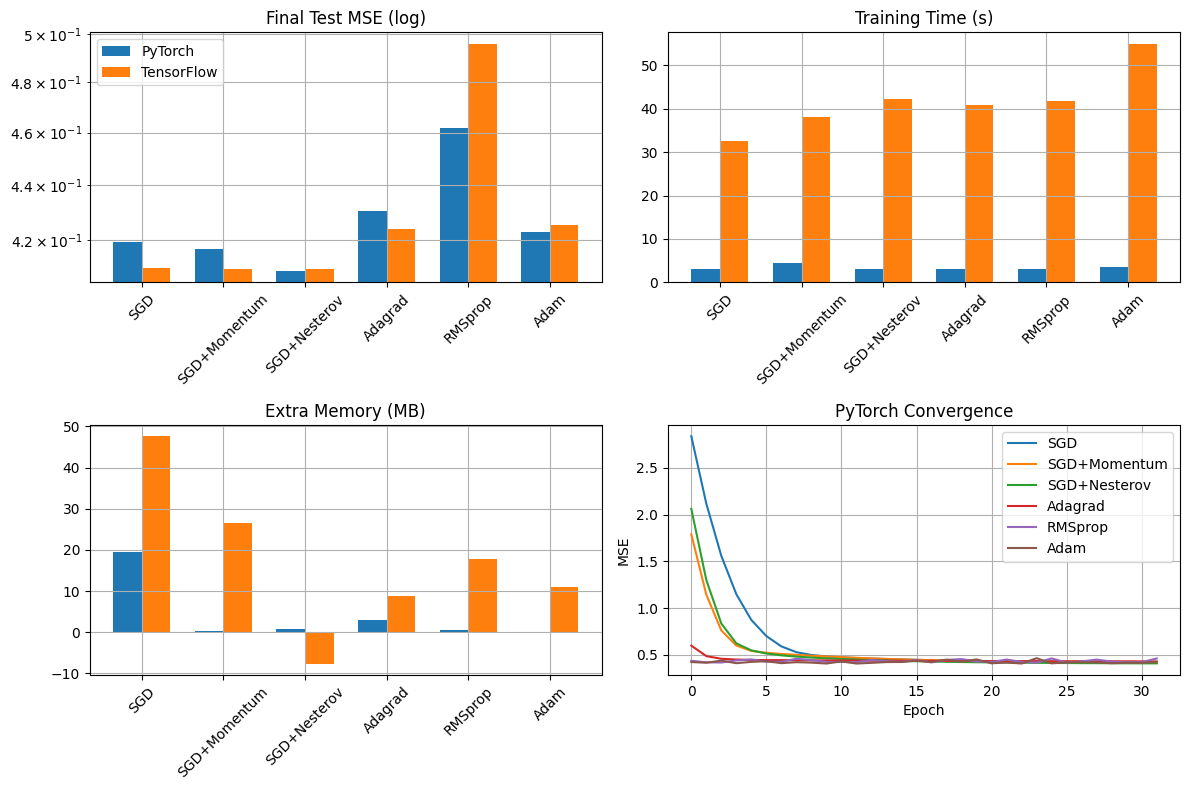

In [27]:
optimisers = ["SGD", "SGD+Momentum", "SGD+Nesterov", "Adagrad", "RMSprop", "Adam"]
results = []
for opt_name in optimisers:
    results.append(
        train_torch(opt_name, Xtr_t, ytr_t, Xte_t, yte_t, EPOCHS, BATCH, LR)
    )
for opt_name in optimisers:
    results.append(
        train_tf(opt_name, Xtr_tf, ytr_tf, Xte_tf, yte_tf, EPOCHS, BATCH, LR)
    )

summarise(results)
plot(results)